## SampleStreetNetwork

The code to sample points on the street network and download Street View Images for each location is available in the script:

 - [llm/python/5-street_view_embeddings.ipynb](../../../../python/5-street_view_embeddings.ipynb)

If you run that script you can choose to have it download images, or just display the points abd images that are currently available in the cache. That was part of another piece of work.

This code (**which you shouldn't need to run**) will take all of those images and associated metadata and put them into a single HFS file which is easier to distrbute and work with. Later scripts in this project use that HFS file.

In [1]:
import h5py
import os
import io
import pickle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from directory_filepaths import * # Note this also includes 'h5_filename'; the location of the database

# The cache assumes a different relative locations, we need to prepend it with this
image_base_dir = "../../../"

In [2]:
# Read the point metadata
points_data_cache = "../../../../data/airbnb-manchester/points_with_embeddings.pkl"

with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)


In [ ]:
# Look at the structure of the first record
point_records[0:1]

Create the database

In [5]:
def load_image(path):
    """Load image file into uint8 numpy array (H, W, 3)."""
    img = Image.open(image_base_dir + path).convert("RGB")
    return np.array(img, dtype=np.uint8)


def load_jpeg_bytes(path):
    """
    Read a JPEG file as raw bytes and return a 1D numpy array (dtype=uint8).
    """
    with open(image_base_dir + path, "rb") as f:
        data = f.read()
    # Store as uint8 vector for HDF5 vlen dtype
    return np.frombuffer(data, dtype=np.uint8)


def create_hdf5(points, output_path=h5_filename):
    N = len(points)

    # Load one image to determine shape
    sample_img = load_image(points[0]["image_files"][0])
    H, W, C = sample_img.shape

    with h5py.File(output_path, "w") as f:
        # === METADATA DATASETS ===
        f.create_dataset("point_id", (N,), dtype="int32")
        f.create_dataset("latitude", (N,), dtype="float64")
        f.create_dataset("longitude", (N,), dtype="float64")
        f.create_dataset("date", (N,), dtype="S10")  # ASCII up to length 10 ("YYYY-MM")

        
        # (Optional) keep original image paths for traceability
        f.create_dataset("image_paths", (N, 4), dtype="S512")
      
        # Track whether we successfully stored a JPEG for each of the 4 headings
        f.create_dataset("images_present", (N, 4), dtype="bool")
        
        # === IMAGE DATASET (JPEG bytes via variable-length uint8) ===
        img_ds = f.create_dataset("images_jpeg", shape=(N, 4), dtype=h5py.vlen_dtype(np.dtype("uint8")))

        
        # === WRITE ALL RECORDS ===
        for i, pt in enumerate(points):
            if i % 5000 == 0:
                print(f"Processed {i} points...")

            # Write metadata (do this regardless of image issues to keep index stable)
            f["point_id"][i] = pt["point_id"]
            f["latitude"][i] = pt["latitude"]
            f["longitude"][i] = pt["longitude"]
            f["date"][i] = np.bytes_(pt["date"])

            # Store image paths
            for j in range(4):
                f["image_paths"][i, j] = np.bytes_(pt["image_files"][j])

            # Load/store the 4 images as JPEG bytes
            for j, img_rel_path in enumerate(pt["image_files"]):
                try:
                    jpeg_vec = load_jpeg_bytes(img_rel_path)  # 1D uint8 array
                    img_ds[i, j] = jpeg_vec
                    f["images_present"][i, j] = True
                except FileNotFoundError as ex:
                    # Keep alignment: store an empty array and mark as missing
                    print(f"[WARN] Missing image for point {i}, slot {j}: {ex}")
                    img_ds[i, j] = np.array([], dtype=np.uint8)
                    f["images_present"][i, j] = False
                except Exception as ex:
                    # Any other read/decode error
                    print(f"[WARN] Error for point {i}, slot {j}: {ex}")
                    img_ds[i, j] = np.array([], dtype=np.uint8)
                    f["images_present"][i, j] = False

    print(f"HDF5 file written to: {output_path}")

create_hdf5(point_records, h5_filename)

Processed 0 points...
Processed 5000 points...
[WARN] Missing image for point 9158, slot 1: [Errno 2] No such file or directory: '../../../../data/airbnb-manchester/street_images/point9285_heading90.jpg'
Processed 10000 points...
Processed 15000 points...
[WARN] Missing image for point 18664, slot 3: [Errno 2] No such file or directory: '../../../../data/airbnb-manchester/street_images/point18959_heading270.jpg'
HDF5 file written to: ../../../../data/embeddings/sample_points_cache/street_data.h5


Check what was written

In [6]:
f = h5py.File(h5_filename, "r")
print("Keys are: ", list(f.keys()))

Keys are:  ['date', 'image_paths', 'images_jpeg', 'images_present', 'latitude', 'longitude', 'point_id']


In [7]:
print(f"H5 ontains {len(f["point_id"])} items")

H5 ontains 18897 items


In [8]:
print("Point 0 metadata:")
for x in ['date', 'latitude', 'longitude', 'point_id']:
    print(f"\t{x}: {f[x][0]}")

Point 0 metadata:
	date: b'2025-03'
	latitude: 53.457824
	longitude: -2.225911
	point_id: 0


Show images for a point:

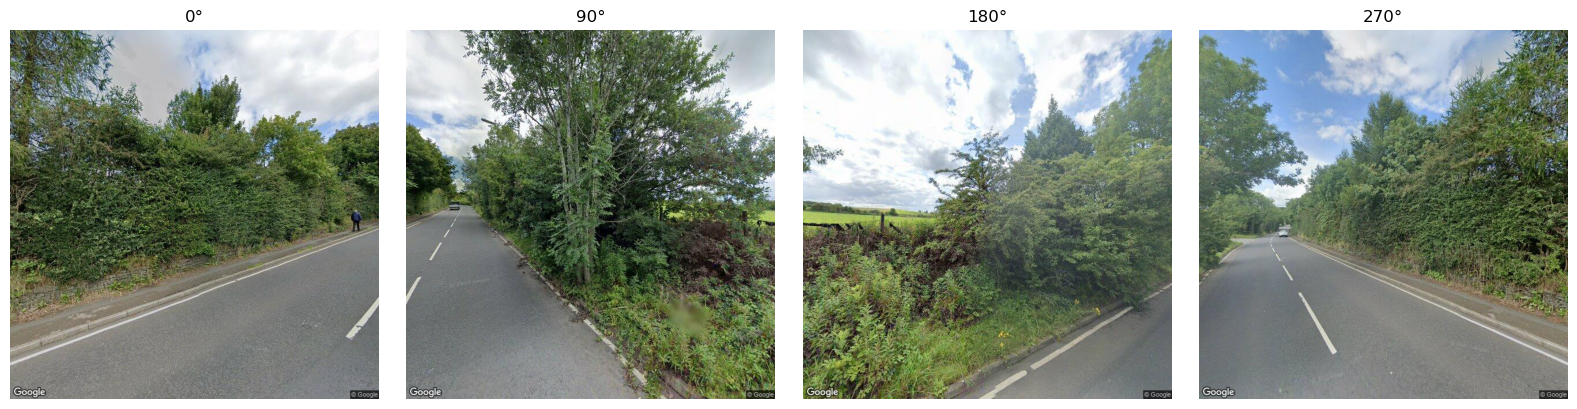

In [13]:
def read_image_from_h5(h5_file, point_index, slot=0):
    """
    Returns a PIL.Image for the given point and slot (0,1,2,3).
    """
    present = bool(h5_file["images_present"][point_index, slot])
    if not present:
        raise FileNotFoundError(f"No image stored at point {point_index}, slot {slot}")

    jpeg_bytes = h5_file["images_jpeg"][point_index, slot].tobytes()
    return Image.open(io.BytesIO(jpeg_bytes)).convert("RGB")


point_index = 1234

imgs = f["images_jpeg"][point_index]   # shape: (4, H, W, 3)
_id = f["point_id"][point_index] 
# Create 1x4 figure
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

headings = [0, 90, 180, 270]

for j, ax in enumerate(axes):
    if not f["images_present"][point_index, j]:
        ax.set_title(f"{headings[j]}° (missing)")
        ax.axis("off")
        continue

    jpeg_bytes = f["images_jpeg"][point_index, j].tobytes()
    img = Image.open(io.BytesIO(jpeg_bytes)).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"{headings[j]}°")
    ax.axis("off")


plt.tight_layout()
plt.show()


In [14]:
# Find a particular point

#target_id = 9158
target_id = 1251

ids = f["point_id"][:]

# Find indices where it matches
matches = np.where(ids == target_id)[0]
if len(matches) == 0:
    raise KeyError(f"point_id {target_id} not found")
row = int(matches[0])


rec = {
    "point_id": int(f["point_id"][row]),
    "latitude": float(f["latitude"][row]),
    "longitude": float(f["longitude"][row]),
    "date": f["date"][row].decode("ascii"),
    #"images": f["images"][row],  # (4, H, W, 3)
}

rec

{'point_id': 1251,
 'latitude': 53.587933,
 'longitude': -2.372983,
 'date': '2023-08'}